# Modeling process to driver's applicantions engagement

## 1. Libraries

In [1]:
import numpy as np # data manipulation
import pandas as pd # data manipulation
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization

from tools import *
from datetime import * # data transformation
import calendar # data transformation

%matplotlib inline

## 2. Import data and first exploration

The first step was loaded the data and explore its structure, so I could understand better which kind of variables I was treating

In [2]:
dataset = pd.read_excel('data.xlsx')

In [3]:
print 'There are', len(dataset), 'records in the dataset'

There are 54681 records in the dataset


In [4]:
dataset.sample(5)

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
33134,33135,Strark,mac,Organic,2016-01-24,2016-02-22,NaN,NaN,NaN,NaN,NaN
48881,48882,Strark,ios web,Referral,2016-01-14,2016-01-14,2016-01-14 00:00:00,Nissan,Sentra,2015.0,2016-01-16 00:00:00
44563,44564,Berton,ios web,Referral,2016-01-17,2016-01-22,NaN,NaN,NaN,NaN,NaN
43361,43362,Berton,android web,Organic,2016-01-16,2016-01-22,NaN,NaN,NaN,NaN,NaN
48812,48813,Berton,ios web,Organic,2016-01-10,NaT,NaN,NaN,NaN,NaN,NaN


In [5]:
start_driving = dataset.first_completed_date.notnull() 
not_bgc = dataset.bgc_date.isnull()
not_vehicle_info = dataset.vehicle_added_date.isnull()
print 'There are', sum((start_driving) & ((not_bgc) | (not_vehicle_info))), 'accounts with a completed trip but missing information'

There are 265 accounts with a completed trip but missing information


In [6]:
dataset = dataset[~((start_driving) & ((not_bgc) | (not_vehicle_info)))]

Our variables are:

In [7]:
for var in dataset.columns: print var

id
city_name
signup_os
signup_channel
signup_date
bgc_date
vehicle_added_date
vehicle_make
vehicle_model
vehicle_year
first_completed_date


**Note**: The *data description* provided in the instructions has some differences with the data (*.xlsx*), some the column names do not match, the format of certain dates or categories in variables.

I set the index with the id in the data so I can easily managed the records

In [8]:
dataset = dataset.set_index('id')

A dataset contains different types of variables. Then, I'd like to know the inherent structure of variables

In [9]:
dataset.dtypes

city_name                       object
signup_os                       object
signup_channel                  object
signup_date             datetime64[ns]
bgc_date                datetime64[ns]
vehicle_added_date              object
vehicle_make                    object
vehicle_model                   object
vehicle_year                   float64
first_completed_date            object
dtype: object

### 2.1. Null values

One of the first things to investigate in any dataset is the null values, the following table shows the proportion of null values against the total of records in the variable:

In [10]:
dataset.isnull().sum() / len(dataset)

city_name               0.000000
signup_os               0.125386
signup_channel          0.000000
signup_date             0.000000
bgc_date                0.400342
vehicle_added_date      0.758637
vehicle_make            0.757020
vehicle_model           0.757020
vehicle_year            0.757020
first_completed_date    0.892091
dtype: float64

**Decision:** All variables contain a considerable proportion of null values then I decided to not remove any variable. This proportion should be reduced from process controls, reviewing the user experience and facility when a candidate tries to fill an application or other factor that affects the data quality in the information

### 2.2. Categorical variables

Next, I looked more deeply into the variables. Categorical data are those who -as its name says- are represented by categories and for this reason can not be used in numerical operation.

**Note: Most of the variables seems to be categorial. Indeed, the data set only have one numerical variable (vehicle_year).**

In [11]:
disc = ['city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'vehicle_model']

I could vizualize more easily the variables in a barplot. The following cell displays a barplot for each categorical variable in the data, grouping those categories that do not represent a considerable proportion in total records.

**Decision:** Then, if a variable's category does not represent at least the *1%* of the total counts, it will be added to **Other** category.

**Note:** After inspect each variable (*vehicle_model* for example, has a looot of categories), I decided to group and create the *Other* category, so the model won't be affected by overfitting. 

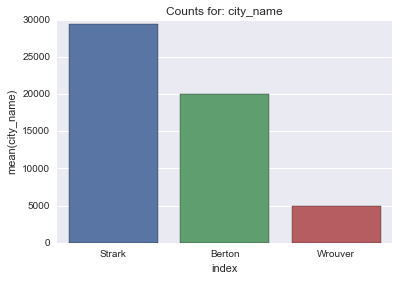

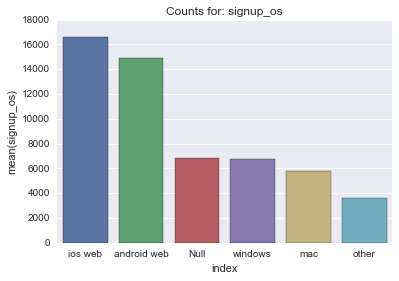

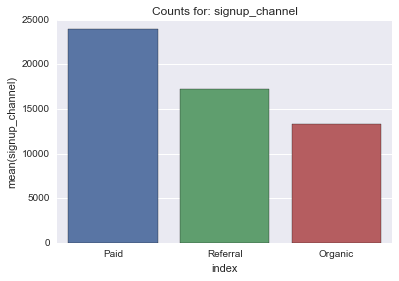

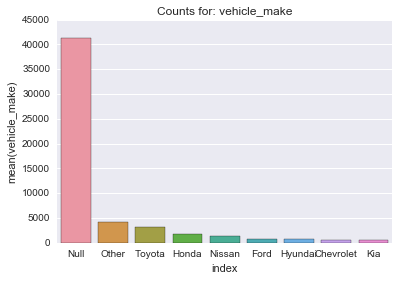

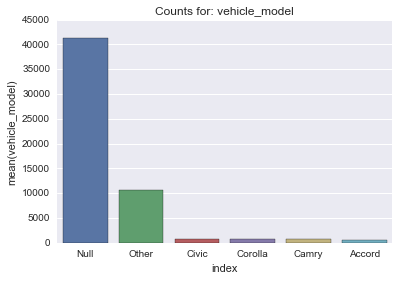

In [12]:
dataset_disc = dataset.copy()
threshold = 0.01
null_name = 'Null'
for i, var_disc in enumerate(disc):
    # if var_disc != 'signup_os': continue
    
    dataset_disc[disc[i]] = dataset_disc[disc[i]].fillna(null_name)
    categories = pd.DataFrame(dataset_disc[disc[i]].fillna(null_name).value_counts() / len(dataset_disc)).reset_index()
    categories.sort_values(disc[i], inplace=True, ascending=False)

    lst = []
    for j, row in categories.iterrows():
        if row[disc[i]] < threshold:
            lst.append([row['index'], row[disc[i]]])
    group_df = pd.DataFrame(lst, columns=['feature', 'pct'])

    lst = categories[categories[disc[i]] >= threshold]['index'].tolist()
    lst = ['"' + x + '"' for x in lst]

    if group_df.pct.sum() > threshold:
        dataset_disc[disc[i]] = np.where(dataset_disc[disc[i]].isin(group_df.feature.tolist()), 'Other', dataset_disc[disc[i]])

    aux = pd.DataFrame(dataset_disc[var_disc].value_counts())
    plt.title('Counts for: ' + var_disc)
    sns.barplot(x='index', y=var_disc, data=aux.reset_index())
    plt.show()
    print 

### 2.3. Datetime variables

Date variables can be extra helpful when feature extraction comes. The document provided for the creativity test establish the data is a cohort from January 2015, **but all dates correspond to January 2016**. From now, I considered that the cohort have been collected in 2016.

**Note**: The object type for date variables are not the same (*vehicle_added_date* is an *object* indicating the variable hasn't the same format for all records)

In [13]:
dataset_disc['vehicle_added_date'] = pd.to_datetime(dataset_disc.vehicle_added_date)
dataset_disc['first_completed_date'] = pd.to_datetime(dataset_disc.first_completed_date)

In [14]:
dataset_disc.dtypes

city_name                       object
signup_os                       object
signup_channel                  object
signup_date             datetime64[ns]
bgc_date                datetime64[ns]
vehicle_added_date      datetime64[ns]
vehicle_make                    object
vehicle_model                   object
vehicle_year                   float64
first_completed_date    datetime64[ns]
dtype: object

With a cleaning in the date variables, I could observe the following about them:

In [15]:
historical_signups = dataset_disc.reset_index()[['id', 'signup_date']].groupby('signup_date').count().reset_index()
historical_bgcs= dataset_disc.reset_index()[['id', 'bgc_date']].groupby('bgc_date').count().reset_index()

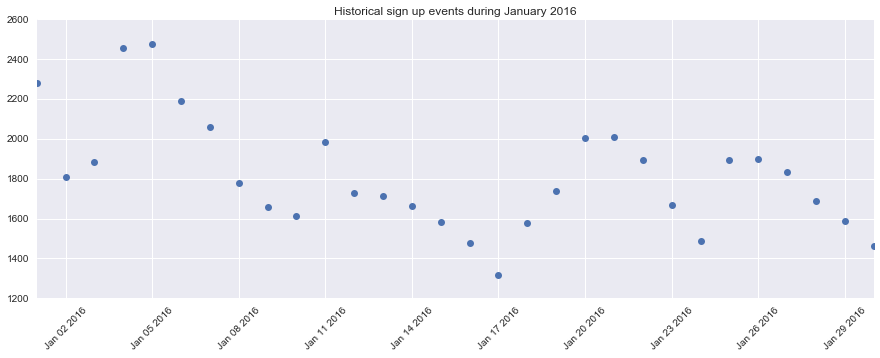

In [16]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=45)
plt.title('Historical sign up events during January 2016')
plt.plot_date(x='signup_date', y='id', data=historical_signups);

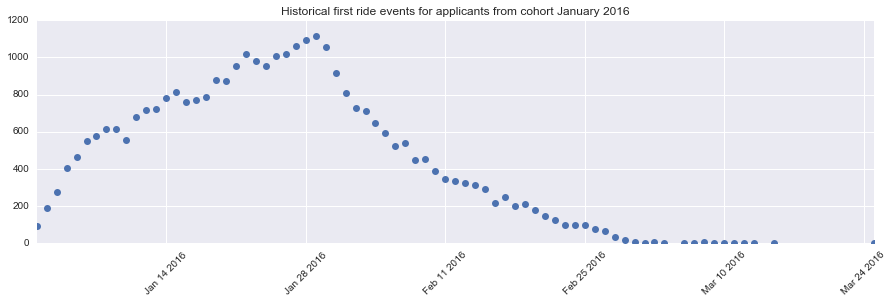

In [17]:
plt.figure(figsize=(15, 4))
plt.xticks(rotation=45)
plt.title('Historical first ride events for applicants from cohort January 2016')
plt.plot_date(x='bgc_date', y='id', data=historical_bgcs);

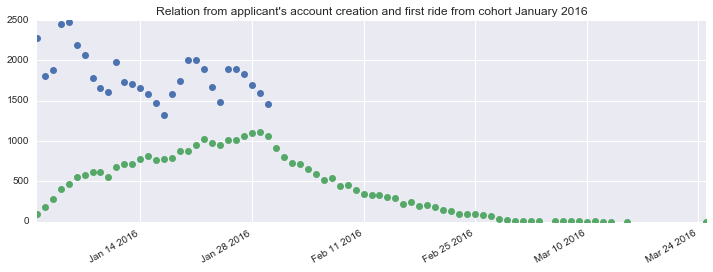

In [18]:
fig = plt.figure(figsize=(12, 4))

plt.xticks(rotation=45)
plt.plot_date(x='signup_date', y='id', data=historical_signups)
plt.plot_date(x='bgc_date', y='id', data=historical_bgcs)
plt.title("Relation from applicant's account creation and first ride from cohort January 2016")

fig.autofmt_xdate()
plt.show()

**Notes**: As I observed in the preciding visualizacion, the number of accounts created during January 2015 seems to have a cyclic effect, this can be due to the day of the week. It's more reasonable fill an account during the weekend, **Friday** and **Saturday**.

It appers most of the applicants who start driving begin their process in January and they started to drive in less than a month.

**Suggestion**: Determinate the factors related to the efficience for a applicant to finish their application and immediately start to driving.

**Decision**: I could obtain more information extracting the **week day** in which the account was created.

### 2.4. Numerical variables

The only numerical value that we have is *vehicle_year*. Considering this variable is discrete I observed that exist vehicles's models with a *year* equals to 0, which is pretty imposible.

In [19]:
# discrete variable
dataset_disc.vehicle_year.fillna('Null').value_counts()

Null      41194
2015.0     2402
2014.0     1655
2013.0     1451
2016.0     1150
2012.0     1122
2007.0      710
2011.0      702
2008.0      659
2010.0      645
2006.0      550
2009.0      513
2005.0      450
2004.0      369
2003.0      350
2002.0      251
2001.0      169
2000.0       29
1999.0       14
1998.0       10
2017.0        6
1997.0        6
1996.0        4
0.0           4
1995.0        1
Name: vehicle_year, dtype: int64

**Decision**: I established a year threshold (I think, Uber has a policy in which you can't be an partner if you haven't a recent vehicle, of course this is not equal for all regions where Uber operates) for the vehicle's year, then we can remove those four records from our set.

**Note**: 6 vehicles are registred with a year **2017**, the only explanation is [Dr. Emmett Brown](https://en.wikipedia.org/wiki/Back_to_the_Future) wanted to be an Uber partner and he traveled in time from 2017 to 2016. Or maybe some error in data. I eliminated those records.

In [20]:
year_threshold = 1990
dataset_disc = dataset_disc[((year_threshold <= dataset_disc.vehicle_year) & (dataset_disc.vehicle_year <= 2016)) | (dataset_disc.vehicle_year.isnull())]

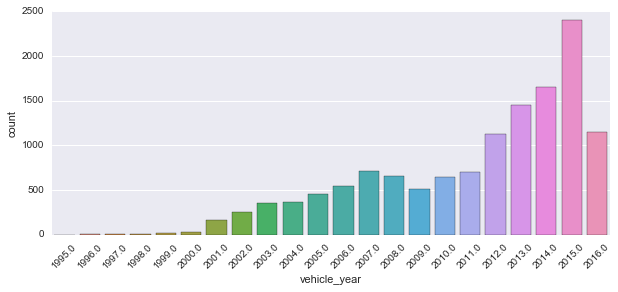

In [21]:
plt.figure(figsize=(10, 4))
sns.countplot(x='vehicle_year', data=dataset_disc)
plt.xticks(rotation=45)
plt.show()

As I expected, most of vehicles are recent (a year before the cohort was obtained). It's interesting to note that many vehicles are from **2007**, this can be help me to determinate if some who creates an account with an old car is able to start to drive.

## 3. Target variable

Now, after looking our variables is time to create our target variable. The purpose of the model is to determinate the relationship between the dependend variables so I can explain (*and predict!*) which person is more likely to start driving.

The target variable can be easily make, if a record has a non null value in the variable *first_completed_date* then s/he was able to create her/his account and start to drive! 

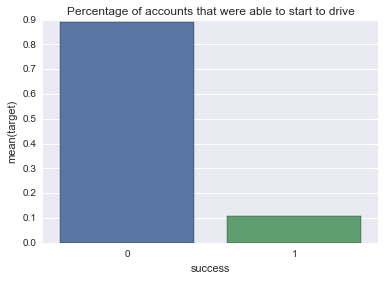

In [22]:
dataset_disc['target'] = np.where(dataset_disc.first_completed_date.isnull(), 0, 1)
target = pd.DataFrame(data=dataset_disc.target.value_counts(True))
target['success'] = [0, 1]

plt.title('Percentage of accounts that were able to start to drive')
sns.barplot(x='success', y="target", data=target);
plt.show()

### Only a ~ 11% of accounts from the cohort of January 2016 started to drive in Uber

## 4. Featuring engineering

Once I looked to the original data, I created extra information that can be useful to the model.

**Decision**: Based on my previous exploratory analysis I created the following variables:

* **signup_to_bgc**: Number of days to upload the background check since the account creation
* **signup_to_vehicle**: Number of days to upload the vehicle information since the account creation
* **first_info**: What information was uploaded first? Background? Vehicle's info? At the same day?
* **day_week**: Day of the week the the account was created
* **web_mobile**: What platform was used to create the account?

In [23]:
dataset_disc['signup_to_bgc'] = dataset_disc.apply(lambda x: (x['bgc_date'] - x['signup_date']).days if x['bgc_date'] is not pd.NaT else np.NaN, axis=1)
dataset_disc['signup_to_vehicle'] = dataset_disc.apply(lambda x: (x['vehicle_added_date'] - x['signup_date']).days if x['vehicle_added_date'] is not pd.NaT else np.NaN, axis=1)

**Decision**: After reviewing the variables created, it's imposible to updated any kind of information if you didn't create your account first. So I decided to remove this data from the data.

In [24]:
dataset_disc = dataset_disc[(dataset_disc.signup_to_bgc >= 0) | (dataset_disc.signup_to_bgc.isnull())]
dataset_disc = dataset_disc[(dataset_disc.signup_to_vehicle >= 0) | (dataset_disc.signup_to_vehicle.isnull())]

In [25]:
print 'At this point we have lost', str(round(100.0*(1 - 1.*len(dataset_disc)/len(dataset)), 2)) + '% of the original data'

At this point we have lost 0.02% of the original data


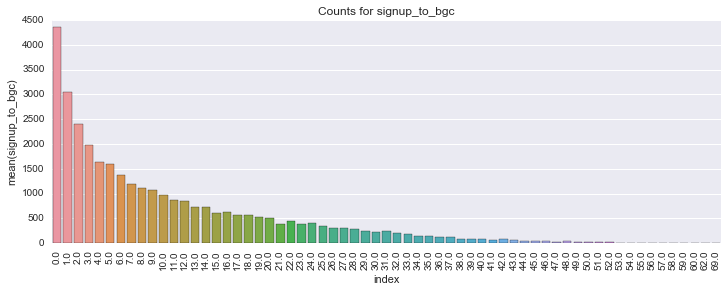

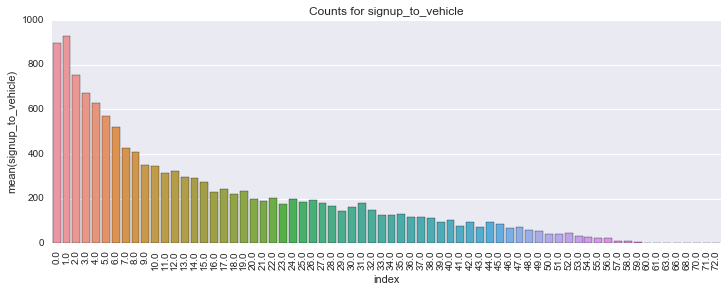

In [26]:
new_cont = ['signup_to_bgc', 'signup_to_vehicle']
for var_cont in new_cont:
    aux = pd.DataFrame(dataset_disc[var_cont].value_counts())
    
    plt.figure(figsize=(12, 4))
    plt.title('Counts for ' + var_cont)
    sns.barplot(x='index', y=var_cont, data=aux.reset_index())
    plt.xticks(rotation=90)
    plt.show()
    print 

In [27]:
dataset_disc['first_info'] = dataset_disc.apply(lambda x: what_first(x['signup_to_bgc'], x['signup_to_vehicle']), 
                                                axis=1)

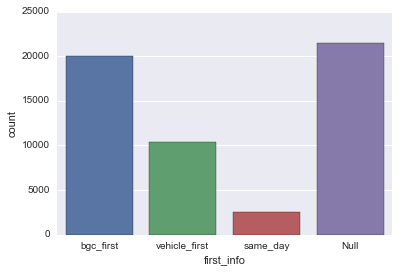

In [28]:
sns.countplot(x='first_info', data=dataset_disc.fillna('Null'), order=['bgc_first', 'vehicle_first', 'same_day', 'Null'])
plt.show()

**Note**: As I believed, the *background check* is the information that people often upload first. But not so far are those who upload their *vehicle information* before their background check. An finally, a few people that upload at the **same day** both requirements. Could be reasonable thinking that if a person uploads all her/his information in the same day has more interest in being part of Uber.

**Suggestion**: Why many people uploads the background information first? Maybe the **vehicle information section** its less intuivite or complicated.

In [29]:
dataset_disc['day_week'] = dataset_disc.signup_date.apply(lambda x: calendar.day_abbr[x.isoweekday() - 1])

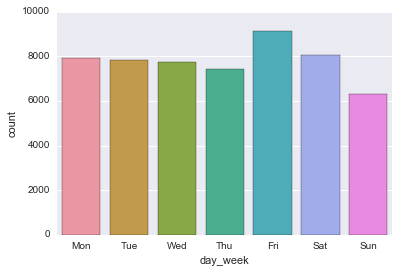

In [30]:
sns.countplot(x='day_week', data=dataset_disc.fillna('Null'), order=list(calendar.day_abbr))
plt.show()

Ha! As I suspected! **Friday** and **Saturday** are the day in which people tend to create an account... But, there is not relation that lead us to think people only use the weekend to advance in the process to make a first ride.

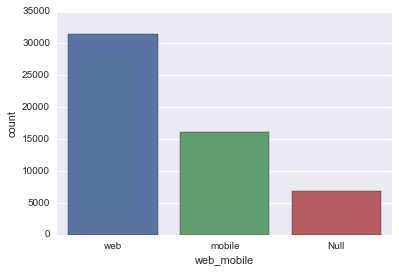

In [31]:
dataset_disc['web_mobile'] = dataset[dataset.reset_index()['id'].isin(dataset_disc.reset_index().id.tolist()).tolist()].signup_os.apply(lambda x: web_mobile(x))
sns.countplot(x='web_mobile', data=dataset_disc.fillna('Null'))
plt.show()

Finally, I created a new variable that classifies by general platform the account's creation. An account can be created in the web site or a mobile.

In [32]:
new_disc = ['first_info', 'day_week', 'web_mobile']

In [33]:
disc += new_disc
cont = ['vehicle_year'] + new_cont

In [34]:
print disc
print cont

['city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'vehicle_model', 'first_info', 'day_week', 'web_mobile']
['vehicle_year', 'signup_to_bgc', 'signup_to_vehicle']


In [35]:
for var in dataset_disc.columns: print var

city_name
signup_os
signup_channel
signup_date
bgc_date
vehicle_added_date
vehicle_make
vehicle_model
vehicle_year
first_completed_date
target
signup_to_bgc
signup_to_vehicle
first_info
day_week
web_mobile


**Decision**: Having this variables and acoriding to the binary classification problem, I decided to model a logistic model to predict the likelihood for someone to created an account and finally start to drive.

For this purpose, I will calculate the [iv](https://support.sas.com/resources/papers/proceedings13/095-2013.pdf) metric to select the best features to create the model. Before that, I will discretize the continuous variables into optimal categories (using a decision tree classifier) so I can mesuare the [woe](https://support.sas.com/resources/papers/proceedings13/095-2013.pdf) values from each categorical and discrete variable.

Finally, using the **woe variables** I will fit a logistic regression to predict the success on partner applications to start to drive a vehicle with Uber.

## 5. Information Value (iv) and Weight of Evidence (WoE)

To find the optimum number of bins to discretize a continuous variable we use a **decision tree classifier**, this allow us **choose the number of groups that maximize the information value**. Using a decision tree with a range of possible depths, the algorithm perform a grind search optimizing the information that can be obtained from the variable if we transformed into a discrete variable.

In [36]:
dataset_all_disc = discretize_opt(dataset_disc, cont, 'target', 0.6, True)

fitting best number of bins for feature vehicle_year ...
best number of bins encountered: 1 with iv 0.10 
fitting best number of bins for feature signup_to_bgc ...
best number of bins encountered: 1 with iv 0.10 
fitting best number of bins for feature signup_to_vehicle ...
best number of bins encountered: 1 with iv 0.10 


In [37]:
disc += [x for x in dataset_all_disc.columns if x.startswith('C_')]

In [38]:
disc

['city_name',
 'signup_os',
 'signup_channel',
 'vehicle_make',
 'vehicle_model',
 'first_info',
 'day_week',
 'web_mobile',
 'C_vehicle_year',
 'C_signup_to_bgc',
 'C_signup_to_vehicle']

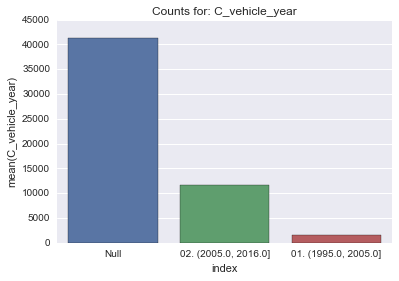

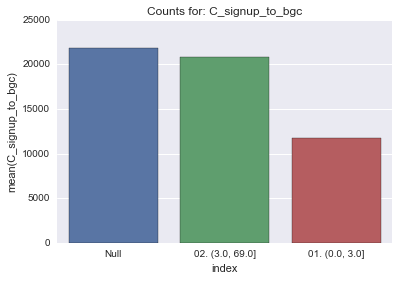

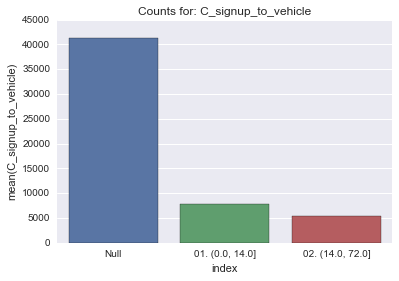

In [39]:
for i, var_disc in enumerate([x for x in dataset_all_disc.columns if x.startswith('C_')]):
    # if var_disc != 'vehicle_model': continue
    
    dataset_all_disc[disc[i]] = dataset_all_disc[disc[i]].fillna(null_name)
    categories = pd.DataFrame(dataset_all_disc[disc[i]].fillna(null_name).value_counts() / len(dataset_all_disc)).reset_index()
    categories.sort_values(disc[i], inplace=True, ascending=False)

    lst = []
    for j, row in categories.iterrows():
        if row[disc[i]] < threshold:
            lst.append([row['index'], row[disc[i]]])
    group_df = pd.DataFrame(lst, columns=['feature', 'pct'])

    lst = categories[categories[disc[i]] >= threshold]['index'].tolist()
    lst = ['"' + x + '"' for x in lst]

    if group_df.pct.sum() > threshold:
        dataset_all_disc[disc[i]] = np.where(dataset_all_disc[disc[i]].isin(group_df.feature.tolist()), 'Other', dataset_all_disc[disc[i]])

    aux = pd.DataFrame(dataset_all_disc[var_disc].value_counts())
    plt.title('Counts for: ' + var_disc)
    sns.barplot(x='index', y=var_disc, data=aux.reset_index())
    plt.show()
    print 

The report of the information values from each variable is presented below. 

**Decision**: I choose the best features for the model according to this criteria. 

**Note**: An infinite iv value represent that a variable's category is not present in one of the target option. In this case, for example, all accounts that have one rided do not hace the **null** category in *first_info* variable, this can be obvious because you can not start to drive if you have not upload your information.

The information value then can detect spurious correlation between the objective variable and depended varibles. I excluded those variables with infinite values.

In [40]:
lst_iv = []

for feature in disc:
    lst_iv.append([feature, iv(dataset_all_disc[feature], dataset_all_disc['target'])])
ivr = pd.DataFrame(lst_iv, columns=['feature', 'iv']).sort_values('iv', ascending=0)
ivr

,feature,iv
3,vehicle_make,inf
4,vehicle_model,inf
5,first_info,inf
8,C_vehicle_year,inf
9,C_signup_to_bgc,inf
10,C_signup_to_vehicle,inf
2,signup_channel,0.355012
1,signup_os,0.282182
7,web_mobile,0.261240
6,day_week,0.014798


In [41]:
best_features = ivr[(0 <= ivr['iv']) & (ivr['iv'] <= 999)]['feature'].tolist()

The best features are:

In [42]:
for feat in best_features: print feat

signup_channel
signup_os
web_mobile
day_week
city_name


I transform the categorical and discrete variables into weight of evidence to fit the logistic model. 
More info [here](http://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/) and [here](https://stats.stackexchange.com/questions/189568/replacing-variables-by-woe-weight-of-evidence-in-logistic-regression?noredirect=1&lq=1).

In [43]:
dataset_woe = woe_transformation(dataset_all_disc, best_features, 'target')

In [44]:
woe_features = [x for x in dataset_woe.columns if x.startswith('W_')]

In [45]:
woe_features

['W_signup_channel',
 'W_signup_os',
 'W_web_mobile',
 'W_day_week',
 'W_city_name']

## 6. Fit logistic regression

In [46]:
auc = []
X = dataset_woe[woe_features]
y = dataset_woe['target']

In [47]:
logreg = LogisticRegression(n_jobs=-1)
scores = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')

In [48]:
auc.append(scores.mean())

In [49]:
Xt, Xv, yt, yv = train_test_split(X, y, train_size=0.5)
logreg.fit(Xt, yt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
y_pred = logreg.predict_proba(Xt)[:, 1]
auc.append(roc_auc_score(yt, y_pred))

In [51]:
y_pred = logreg.predict_proba(Xv)[:, 1]
auc.append(roc_auc_score(yv, y_pred))

In [52]:
betas = logreg.coef_.tolist()[0]
intercept = logreg.intercept_[0]

In [53]:
betas

[1.274475117734021,
 0.7652322045693352,
 0.5846640404783041,
 0.49540807286112776,
 0.3490378328807099]

In [54]:
intercept

-2.0984955365142071

In [55]:
for feature in woe_features:
    print dataset_woe[[feature[2:], feature]].groupby(feature[2:]).mean().reset_index().sort_values(feature, ascending=False)
    print 

  signup_channel  W_signup_channel
2       Referral          0.690122
0        Organic         -0.304166
1           Paid         -0.637279

     signup_os  W_signup_os
3          mac     0.422964
4        other     0.238051
2      ios web     0.192237
5      windows     0.183369
1  android web    -0.150874
0         Null    -1.962767

  web_mobile  W_web_mobile
1     mobile      0.285630
2        web      0.041107
0       Null     -1.962767

  day_week  W_day_week
5      Tue    0.138943
1      Mon    0.112995
6      Wed    0.081191
4      Thu    0.038999
2      Sat   -0.080861
0      Fri   -0.130120
3      Sun   -0.219138

  city_name  W_city_name
0    Berton     0.079873
1    Strark    -0.020273
2   Wrouver    -0.232121



**NOTE**: Because we are using a transformation of the variable, the interpretation of the beta parameters in the regression model is not the same as we know. Traditionally, the expression $exp(\beta_n)$ means the relation between the increase of the odd's ratio if we increase the variable $x_n$ by one unit.

But with the **woe variables**, beta parameters are the linear bias of each weight-of-evidence. Weight of evidence presents a linear relationship with the natural logarithm of the odds ratio which is the dependent variable in logistic regression.

## 7. Model Performance

In [56]:
print 'AUC for cross validation:', auc[0]
print 'AUC for training set:', auc[1]
print 'AUC for validation set:', auc[2]

AUC for cross validation: 0.738692807583
AUC for training set: 0.741357383719
AUC for validation set: 0.73668488271


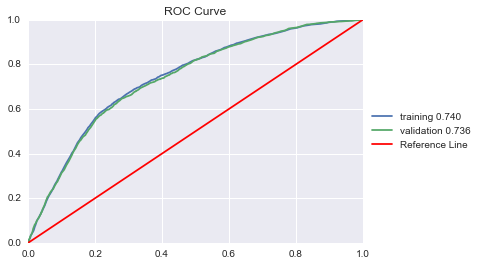

In [57]:
plot_roc_curve(dataset_woe, woe_features, 'target', logreg, train_size=0.7)